## Ground Modeling

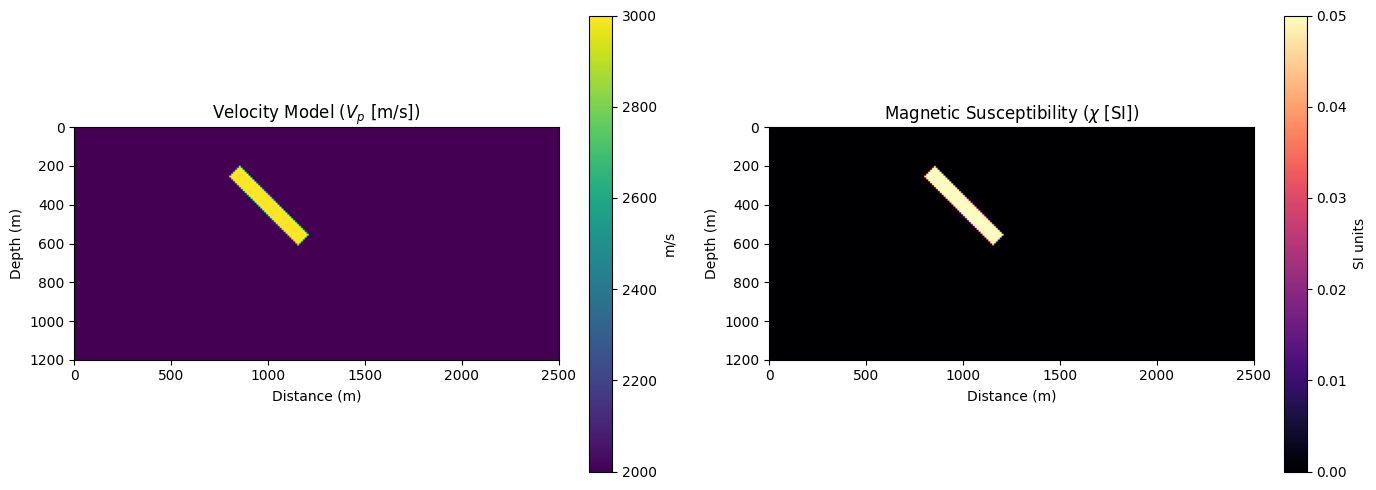

In [1]:
#------ Ground Modeling
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# 1. Grid Setup
nx, nz = 250, 120 # 200, 100          # Number of cells
dx, dz = 10.0, 10.0        # Cell size in meters (2km x 1km total)
x = np.linspace(0, (nx-1)*dx, nx)
z = np.linspace(0, (nz-1)*dz, nz)
X, Z = np.meshgrid(x, z, indexing='ij')

# 2. Dike Parameters
cx, cz = 1000.0, 400.0     # Center of the dike
width = 80.0               # Thickness of the dike
length = 500.0             # Vertical extent
angle = np.radians(45)     # 45-degree dip

# 3. Coordinate Transformation (Rotation)
# Translate to origin
X_rel = X - cx
Z_rel = Z - cz

# Rotate coordinates to align with the dike's dip
X_rot = X_rel * np.cos(angle) - Z_rel * np.sin(angle)
Z_rot = X_rel * np.sin(angle) + Z_rel * np.cos(angle)

# 4. Create the Mask
# Define boundaries in the rotated space
dike_mask = (np.abs(X_rot) < width/2) & (np.abs(Z_rot) < length/2)

# 5. Assign Physical Properties
# Background properties
vp = np.full((nx, nz), 2000.0) # 2500     # Velocity (m/s)
chi = np.zeros((nx, nz))            # Susceptibility (SI)

# Apply the dike properties
vp[dike_mask] = 3000.0 # 4000.0
chi[dike_mask] = 0.05

# 6. Visualization
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

im1 = ax[0].imshow(vp.T, extent=[0, nx*dx, nz*dz, 0], cmap='viridis')
ax[0].set_title("Velocity Model ($V_p$ [m/s])")
plt.colorbar(im1, ax=ax[0], label="m/s")

im2 = ax[1].imshow(chi.T, extent=[0, nx*dx, nz*dz, 0], cmap='magma')
ax[1].set_title("Magnetic Susceptibility ($\chi$ [SI])")
plt.colorbar(im2, ax=ax[1], label="SI units")

for a in ax:
    a.set_xlabel("Distance (m)")
    a.set_ylabel("Depth (m)")

plt.tight_layout()
plt.show()

## FWI measures seismic particle displacement, velocity, or pressure

Generating observed data...


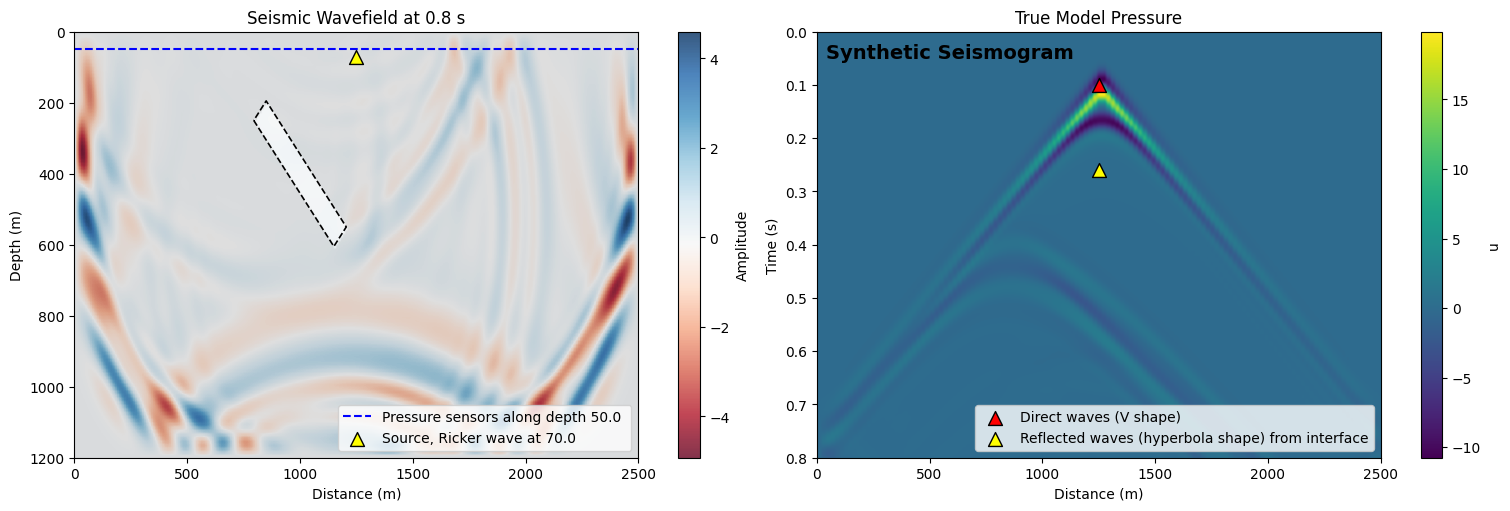

In [2]:
# ------ FWI
# 1. Physical & Grid Parameters
nt = 800 # 800 
dt = 0.001
f0 = 15.0 

# --- NEW: Sponge Layer (Damp Wall) Setup ---
npad = 20 # Thickness of the damp wall
v_damp = np.ones((nx, nz))
damp_factor = 0.01 # Strength of the sponge

for i in range(npad):
    # Quadratic decay towards the edges
    amplitude = 1.0 - (damp_factor * (npad - i)**2 / npad**2)
    v_damp[i, :] *= amplitude          # Left
    v_damp[-(i+1), :] *= amplitude     # Right
    v_damp[:, -(i+1)] *= amplitude     # Bottom

# 2. Source Setup
time = np.arange(nt) * dt
tau = np.pi * f0 * (time - 1.5/f0)
source = (1 - 2*tau**2) * np.exp(-tau**2)

# 3. Create True Model and Initial Guess
v_true=vp

v_current = np.full((nx, nz), 1900.0) # Starting guess (slightly off)

def get_seis(vel):
    """Standard Forward Modeling"""
    u_p, u_n = np.zeros((nx, nz)), np.zeros((nx, nz))
    seis = np.zeros((nt, nx))
    v2dt2 = (vel**2 * dt**2)
    inv_h2 = 1.0 / dx**2
    
    for n in range(nt):
        # Laplacian using slicing (faster than roll)
        lap = np.zeros_like(u_n)
        lap[1:-1, 1:-1] = (u_n[2:, 1:-1] + u_n[:-2, 1:-1] + 
                           u_n[1:-1, 2:] + u_n[1:-1, :-2] - 4*u_n[1:-1, 1:-1]) * inv_h2
        
        u_next = 2*u_n - u_p + v2dt2 * lap
        u_next[nx//2, 7] += source[n] * v2dt2[nx//2, 7]
        
        u_next *= v_damp # --- APPLY SPONGE ---
        
        seis[n, :] = u_next[:, 5] # Receivers at z=5
        u_p, u_n = u_n, u_next
    return seis, u_n

# 4. Generate the "Field Data" we are trying to match
print("Generating observed data...")
d_obs, u_nF = get_seis(v_true)

fig, ax = plt.subplots(1, 2, figsize=(15, 5), layout="constrained") 

bg  = ax[0].imshow(vp.T, extent=[0, nx*dx, nz*dz, 0], cmap='gray', alpha=0.5, aspect='auto')
im1 = ax[0].imshow(u_nF.T, extent=[0, nx*dx, nz*dx, 0], cmap='RdBu', alpha=0.8,  aspect='auto')
ax[0].contour(X, Z, dike_mask, levels=[0.5], colors='black', linewidths=1.2, linestyles='--')

ax[0].axhline(y=5*dx, color='b', linestyle='--', label=f"Pressure sensors along depth {5*dx} ")
ax[0].scatter(nx*dx/2, 7*dx, marker='^', color='yellow', 
              s=100, edgecolors='black', label= f"Source, Ricker wave at {7*dx}" , zorder=10)
ax[0].legend(loc='lower right')
ax[0].set_title(f"Seismic Wavefield at {nt*dt} s")
ax[0].set_xlabel("Distance (m)")
ax[0].set_ylabel("Depth (m)")
fig.colorbar(im1, ax=ax[0], label="Amplitude", fraction=0.046, pad=0.04)

im2 = ax[1].imshow(d_obs[::2, ::2], aspect='auto', extent=[0, nx*dx, nt*dt, 0])

ax[1].annotate('Synthetic Seismogram ', 
            xy=(40, 0.05), xytext=(40, 0.05),
            color='black', fontsize=14, fontweight='bold')
ax[1].scatter(nx*dx/2, 0.1, marker='^', color='red', 
              s=100, edgecolors='black', label= f"Direct waves (V shape)" , zorder=10)
ax[1].scatter(nx*dx/2, 0.26, marker='^', color='yellow', 
              s=100, edgecolors='black', label= f"Reflected waves (hyperbola shape) from interface" , zorder=10)
ax[1].legend(loc='lower right')
ax[1].set_title("True Model Pressure")
ax[1].set_xlabel("Distance (m)")
ax[1].set_ylabel("Time (s)")
fig.colorbar(im2, ax=ax[1], label="u", fraction=0.046, pad=0.04)

#plt.savefig('FWI_1.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

Starting 60 iterations of FWI...
Starting 0th iteration of FWI...
Starting 10th iteration of FWI...
Starting 20th iteration of FWI...
Starting 30th iteration of FWI...
Starting 40th iteration of FWI...
Starting 50th iteration of FWI...


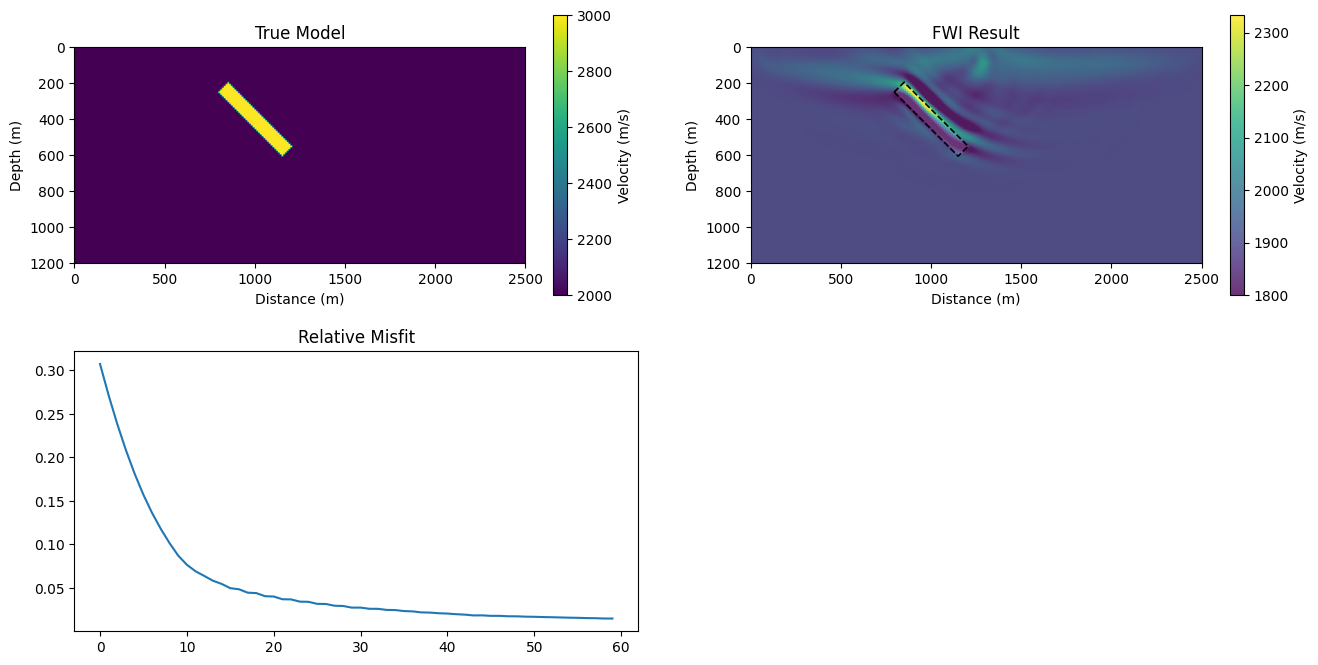

In [3]:
# --- PRE-LOOP: Baseline for Normalization ---
# Calculate the energy of the observed data to use as a 100% scale
initial_data_energy = np.sum(d_obs**2) / 2

n_iterations = 60 #30
step_length = 16 # with smoothed grad ( 1e5 without smooth) 

misfit_history = []
relative_misfit_history = []

# 5. FWI Main Loop
print(f"Starting {n_iterations} iterations of FWI...")
for i in range(n_iterations):
    if i % 10 == 0:
        print(f"Starting {i}th iteration of FWI...")
    # --- STEP A: Forward Modeling ---
    u_p, u_n = np.zeros((nx, nz)), np.zeros((nx, nz))
    u_history = np.zeros((nt, nx, nz)) # Store wavefield for gradient
    seis_syn = np.zeros((nt, nx))
    v2dt2 = (v_current**2 * dt**2)
    
    for n in range(nt):
        lap = np.zeros_like(u_n)
        lap[1:-1, 1:-1] = (u_n[2:, 1:-1] + u_n[:-2, 1:-1] + 
                           u_n[1:-1, 2:] + u_n[1:-1, :-2] - 4*u_n[1:-1, 1:-1]) / dx**2
        u_next = 2*u_n - u_p + v2dt2 * lap
        u_next[nx//2, 7] += source[n] * v2dt2[nx//2, 7] # Source must be the same as in  Forward
        
        u_next *= v_damp # --- APPLY SPONGE ---
        
        u_history[n] = u_n # Save state for adjoint
        seis_syn[n, :] = u_next[:, 5]
        u_p, u_n = u_n, u_next

    # --- STEP B: Calculate Residuals & Misfit ---
    residuals = d_obs - seis_syn 
    misfit = np.sum(residuals**2) /2 # J(v) the success metric is the Least Square   
    misfit_history.append(misfit)
    
    # Normalized Misfit (Percentage of initial error remaining)
    # Starts near 1.0 (100%) and should go down to 0.05 (5%) or lower
    norm_misfit = misfit / initial_data_energy
    relative_misfit_history.append(norm_misfit)
    
    # --- STEP C: Adjoint Modeling (Back-propagation) ---
    adj_p, adj_n = np.zeros((nx, nz)), np.zeros((nx, nz))
    gradient = np.zeros((nx, nz))
    
    for n in range(nt-1, -1, -1): 
        lap = np.zeros_like(adj_n)
        lap[1:-1, 1:-1] = (adj_n[2:, 1:-1] + adj_n[:-2, 1:-1] + 
                           adj_n[1:-1, 2:] + adj_n[1:-1, :-2] - 4*adj_n[1:-1, 1:-1]) / dx**2
        adj_next = 2*adj_n - adj_p + v2dt2 * lap
        adj_next[:, 5] += residuals[n, :] * v2dt2[:, 5] # Inject source = dJ/du (which is the residual) at receivers
        
        adj_next *= v_damp # --- APPLY SPONGE TO ADJOINT ---

        # Gradient computation: dJ/dv = - Integral_t [dL/dv u lambda] dt
        # L is the wave equation operator, (1/v^2)d_tt - d_xx 
        # v is the velocity; u is the forwards field; Lambda is the adjoint field;  dL/dv = (-2/v^3)d_tt
        # dJ/dv = - (2/v^3) * Integral_t ( d_tt u * Lambda ) dt
        # Using a simplified approximation for velocity sensitivity in space (common in FWI): d_tt u = u (like harmonic relation)
        # dJ/dv = - (2/v^3) * Summation( Lambda *u ) along time
        gradient += (adj_n * u_history[n]) * (2.0 / (np.abs(v_current)**3 + 1e-10)) # (adj_n * u_history[n]) Hadamard product
         
        adj_p, adj_n = adj_n, adj_next

    # --- STEP D: Robust Update Model ---
    
    # A. Pre-process Gradient
    # With normalization, use a smaller step_length (max m/s change per iteration)
    # Remove source artifacts and smooth
    grad_smoothed = gaussian_filter(gradient, sigma=3.0)
    # B. Normalize (Prevents the '1e5' explosion)
    grad_norm = grad_smoothed / (np.max(np.abs(grad_smoothed)) + 1e-10)
    
    # 1. Update the velocity
    v_current = v_current - step_length * grad_norm  

    # 2. SAFETY CLIPPING
    # Prevent negative velocities or extreme values that cause 'nan'
    v_current = np.clip(v_current, 1800.0, 3500.0)
    # 3. DYNAMIC STABILITY CHECK
    max_v = np.max(v_current)
    cfl = max_v * dt / dx
    if cfl > 0.707:
        print(f"CRITICAL: Iteration {i} is unstable! CFL={cfl:.2f}")
        # Force velocity down to maintain stability
        v_current = v_current * (0.7 / cfl)

# 6. Final Visualization
plt.figure(figsize=(16, 8))
plt.subplot(221); plt.imshow(v_true.T, cmap='viridis',extent=[0, nx*dx, nz*dx, 0]); plt.title("True Model")
plt.colorbar(label="Velocity (m/s)"); plt.xlabel("Distance (m)"); plt.ylabel("Depth (m)")

plt.subplot(222)
plt.imshow(v_true.T,   extent=[0, nx*dx, nz*dz, 0], cmap='gray', alpha=0.5) # aspect='auto'
im_v_current=plt.imshow(v_current.T, cmap='viridis',extent=[0, nx*dx, nz*dx, 0],alpha=0.8) # aspect='auto'
plt.contour(X, Z, dike_mask, levels=[0.5], colors='black', linewidths=1.2, linestyles='--')
plt.title(f"FWI Result")
plt.colorbar(im_v_current,label="Velocity (m/s)"); plt.xlabel("Distance (m)"); plt.ylabel("Depth (m)")
plt.subplot(223); plt.plot(relative_misfit_history); plt.title("Relative Misfit")
plt.show()
# With this approach, your misfit starts at 1.0. If it goes to 0.1, you know you've reduced the error by 90%.

## Magnetic susceptibility

In [4]:
#--- Susceptibility 
import numpy as np

# --- Setup Sensors ---
# Sensors are at z_index = 5. We get their coordinates:
z_sensor_val = z[5] 
x_sensors = x[:] # Sensors at every x-position
n_sensors = len(x_sensors)
n_model = nx * nz # Total number of voxels

# Initialize G Matrix [Sensors x Voxels]
G = np.zeros((n_sensors, n_model))

# Flatten our grid coordinates for easy looping
x_flat = X.flatten()
z_flat = Z.flatten()

print(f"Building G matrix of size {n_sensors}x{n_model}...")

# --- Fill the G Matrix ---
for i in range(n_sensors):
    dx_vec = x_sensors[i] - x_flat
    dz_vec = z_sensor_val - z_flat # Sensor is above the model cells
    
    r2 = dx_vec**2 + dz_vec**2
    
    # 2D Magnetic Kernel (Simplified for vertical induction)
    # This represents the vertical field response
    G[i, :] = (dz_vec**2 - dx_vec**2) / (r2**2 + 1e-9) # 1e-9 avoids division by zero
    #  size of G must be (Number of Sensors x Number of Voxels)

# --- Create Synthetic Data ---
# Flatten your susceptibility model from the earlier step
chi_true_flat = chi.flatten()

# Synthetic magnetic data: d = G * m
d_mag = G @ chi_true_flat

# Add 3% Gaussian noise to make it realistic
#noise = 0.03 * np.max(np.abs(d_mag)) * np.random.randn(n_sensors)
#d_obs_mag = d_mag + noise
d_obs_mag = d_mag

Building G matrix of size 250x30000...


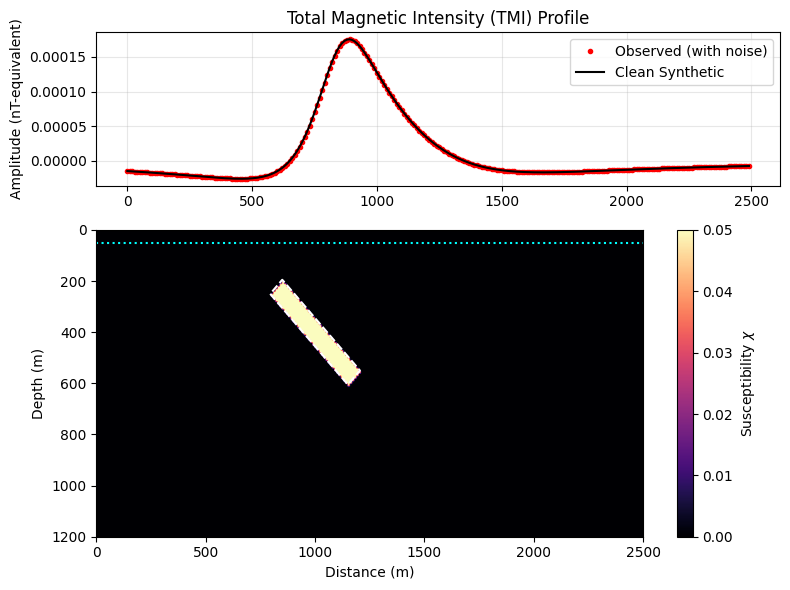

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={'height_ratios': [1, 2]})

# Top Plot: The Magnetic Data (The Synthetic Observed Data)
ax[0].plot(x_sensors, d_obs_mag, 'r.', label="Observed (with noise)")
ax[0].plot(x_sensors, d_mag, 'k-', label="Clean Synthetic")
ax[0].set_title("Total Magnetic Intensity (TMI) Profile")
ax[0].set_ylabel("Amplitude (nT-equivalent)")
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# Bottom Plot: The Ground Truth (Structure)
im = ax[1].imshow(chi.T, extent=[0, nx*dx, nz*dz, 0], cmap='magma', aspect='auto')
ax[1].contour(X, Z, dike_mask, levels=[0.5], colors='white', linestyles='--')
ax[1].set_xlabel("Distance (m)")
ax[1].set_ylabel("Depth (m)")
plt.colorbar(im, ax=ax[1], label="Susceptibility $\chi$")

# Draw a line where the sensors are (at index 5)
ax[1].axhline(y=z[5], color='cyan', linestyle=':', label="Sensor Line")

plt.tight_layout()
plt.show()

Starting Magnetic Inversion...


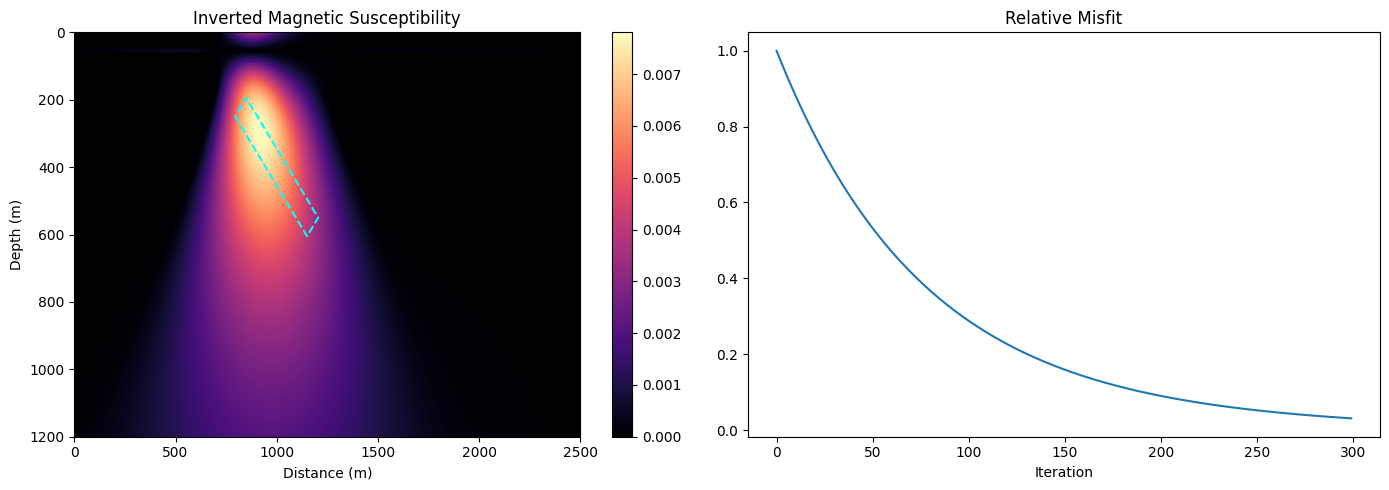

In [6]:
# Calculate the energy of the observed data to use as a 100% scale
initial_data_energy_chi = np.linalg.norm(d_obs_mag)

# --- 1. Depth Weighting ---
# Calculate the 'strength' of each voxel by summing the columns of G
# This helps the inversion see deep objects.
wz = np.sum(G**2, axis=0)**0.5
Wz = wz / np.max(wz)  # Normalized weighting vector

# --- 2. Inversion Parameters ---
n_iterations = 300
alpha = 10.0 # 0.01 # Step size (learning rate)
m_current = np.zeros(n_model) # Start with an empty earth
misfit_hist = []
relative_misfit_history_chi = []

print("Starting Magnetic Inversion...")

for i in range(n_iterations):
    # a. Forward project current model
    d_pred = G @ m_current
    
    # b. Calculate Residual (Data Error)
    residual = d_pred - d_obs_mag
    
    # c. Calculate Gradient (Adjoint)
    # This is G.T multiplied by the residual
    grad = G.T @ residual
    
    # d. Apply Depth Weighting to the gradient
    # This compensates for the 1/r^3 decay
    grad = grad / (Wz + 1e-3) 
    
    # e. Update the Model
    m_current = m_current - alpha * grad
    
    # f. Positivity Constraint (Susceptibility is usually >= 0)
    m_current[m_current < 0] = 0
    
    # g. Track Misfit
    misfit = np.linalg.norm(residual)
    misfit_hist.append(misfit)
    # Normalized Misfit (Percentage of initial error remaining)
    # Starts near 1.0 (100%) and should go down to 0.05 (5%) or lower
    norm_misfit_chi = misfit / initial_data_energy_chi
    relative_misfit_history_chi.append(norm_misfit_chi)
    
    #if i % 20 == 0:
    #    print(f"Iteration {i}: Misfit = {misfit:.4e}")

# --- 3. Final Result Visualization ---
# Reshape the 1D model vector back into the 2D grid
chi_inverted = m_current.reshape((nx, nz))

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot Inverted Result
im1 = ax[0].imshow(chi_inverted.T, extent=[0, nx*dx, nz*dz, 0], cmap='magma', aspect='auto')
ax[0].contour(X, Z, dike_mask, levels=[0.5], colors='cyan', linestyles='--')
ax[0].set_title("Inverted Magnetic Susceptibility")
ax[0].set_xlabel("Distance (m)"); ax[0].set_ylabel("Depth (m)")
plt.colorbar(im1, ax=ax[0])

# Plot Misfit Curve
ax[1].plot(relative_misfit_history_chi)
ax[1].set_title("Relative Misfit")
ax[1].set_xlabel("Iteration")

plt.tight_layout()
plt.show()

## Petrophysics Correlation

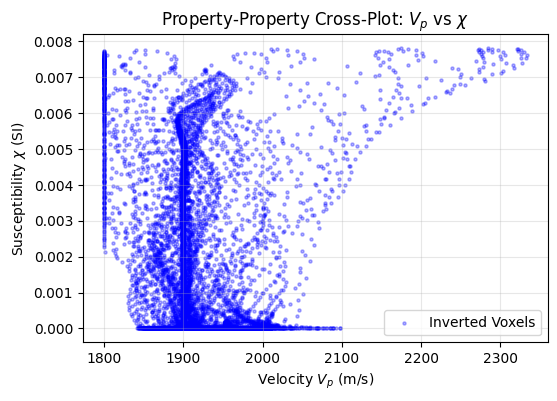

In [7]:
import matplotlib.pyplot as plt

# 1. Prepare the data
# Use your FINAL inverted models (ensure they are the same shape)
vp_final = v_current.flatten()     # From your FWI code
chi_final = chi_inverted.flatten() # From your Magnetic code

# 2. Create the Cross-Plot
plt.figure(figsize=(6, 4))

# Use a hexbin or scatter with alpha to see density
plt.scatter(vp_final, chi_final, c='blue', alpha=0.3, s=5, label='Inverted Voxels')

# 3. Mark the "True" properties for reference
#plt.scatter([2000], [0.0], c='green', s=100, marker='X', label='True Background', edgecolors='k')
#plt.scatter([3000], [0.05], c='red', s=100, marker='X', label='True Dike', edgecolors='k')

# 4. Labeling
plt.title("Property-Property Cross-Plot: $V_p$ vs $\chi$")
plt.xlabel("Velocity $V_p$ (m/s)")
plt.ylabel("Susceptibility $\chi$ (SI)")
plt.grid(True, alpha=0.3)
plt.legend()

plt.show()

In [8]:
import numpy as np

# 1. Calculate Spatial Gradients for both current models
# We use np.gradient to see where the "edges" are
grad_vp_x, grad_vp_z = np.gradient(v_current)
grad_chi_x, grad_chi_z = np.gradient(chi_inverted)

# 2. Calculate the Cross-Gradient (2D cross product)
# This represents the "structural mismatch"
cross_grad = grad_vp_x * grad_chi_z - grad_vp_z * grad_chi_x

# 3. Calculate the "Correction" for each model
# These terms tell the inversion how to move the boundaries to match
# (This is a simplified version of the Gallagher & Meju approach)
joint_corr_vp = cross_grad * grad_chi_z 
joint_corr_chi = cross_grad * grad_vp_z

# 4. Update your models by adding this structural term
# lambda_j is the 'strength' of the joint coupling
lambda_j = 0.1 

alpha_vp = step_length
alpha_mag= alpha
g_wave= grad_norm
g_mag = grad.reshape((nx, nz))
v_current_new     = v_current    - alpha_vp * (g_wave + lambda_j * joint_corr_vp)
chi_inverted_new = chi_inverted - alpha_mag * (g_mag + lambda_j * joint_corr_chi)

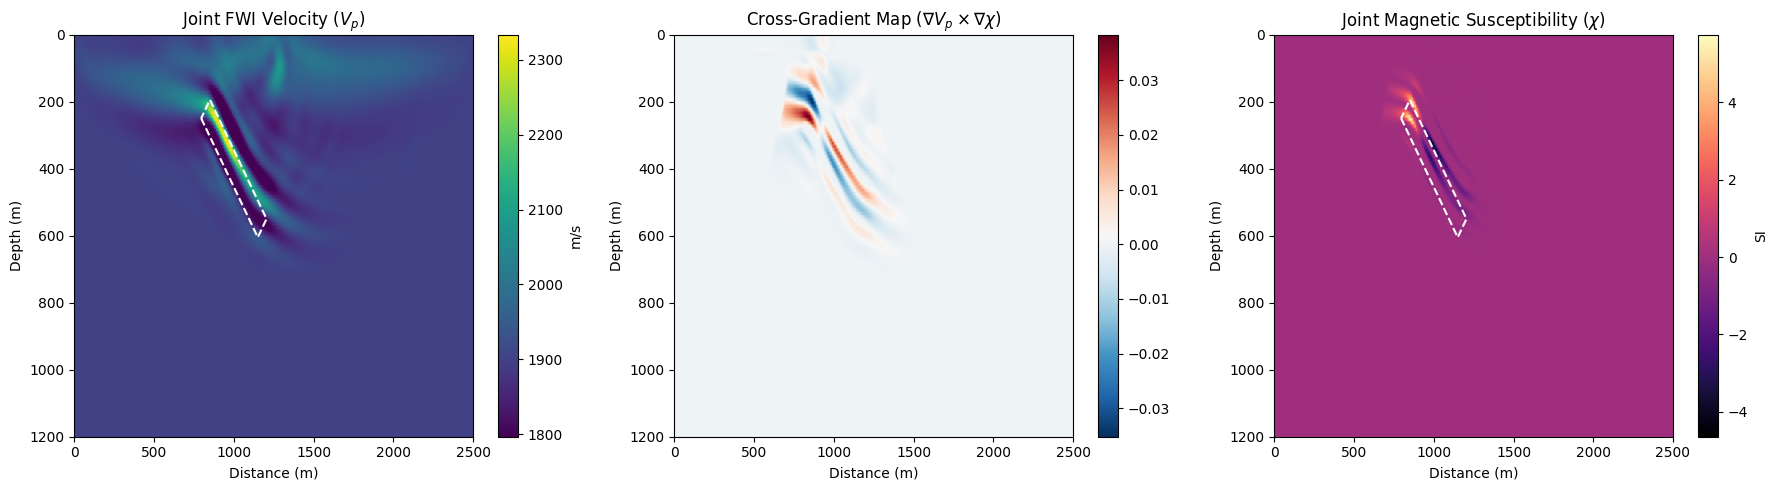

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Updated Velocity (FWI)
im1 = ax[0].imshow(v_current_new.T, extent=[0, nx*dx, nz*dz, 0], cmap='viridis', aspect='auto')
ax[0].contour(X, Z, dike_mask, levels=[0.5], colors='white', linestyles='--')
ax[0].set_title("Joint FWI Velocity ($V_p$)")
plt.colorbar(im1, ax=ax[0], label="m/s")

# Plot 2: The Structural Mismatch (Cross-Gradient)
# This map shows where the boundaries don't align
im2 = ax[1].imshow(cross_grad.T, extent=[0, nx*dx, nz*dz, 0], cmap='RdBu_r', aspect='auto')
ax[1].set_title(r"Cross-Gradient Map ($\nabla V_p \times \nabla \chi$)")
plt.colorbar(im2, ax=ax[1])

# Plot 3: Updated Susceptibility (Magnetic)
im3 = ax[2].imshow(chi_inverted_new.T, extent=[0, nx*dx, nz*dz, 0], cmap='magma', aspect='auto')
ax[2].contour(X, Z, dike_mask, levels=[0.5], colors='white', linestyles='--')
ax[2].set_title("Joint Magnetic Susceptibility ($\chi$)")
plt.colorbar(im3, ax=ax[2], label="SI")

for a in ax:
    a.set_xlabel("Distance (m)")
    a.set_ylabel("Depth (m)")

plt.tight_layout()
plt.show()
## if error, change Lambda_j

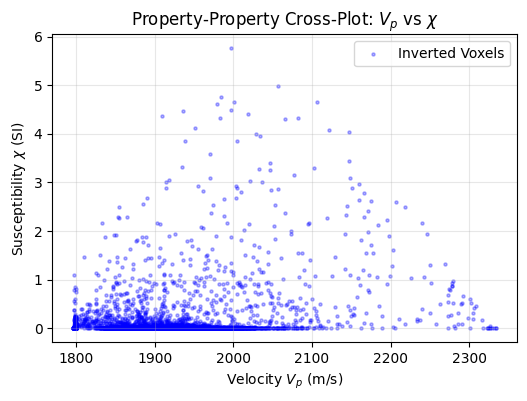

In [10]:
# 1. Prepare the data
# Use your FINAL inverted models (ensure they are the same shape)
vp_final_2 = v_current_new.flatten()     # From your FWI code
chi_final_2 = np.abs(chi_inverted_new.flatten()) # From your Magnetic code

# 2. Create the Cross-Plot
plt.figure(figsize=(6, 4))
plt.scatter(vp_final_2, chi_final_2, c='blue', alpha=0.3, s=5, label='Inverted Voxels')
# Use a hexbin or scatter with alpha to see density

# 3. Mark the "True" properties for reference
#plt.scatter([2000], [0.0], c='green', s=100, marker='X', label='True Background', edgecolors='k')
#plt.scatter([3000], [0.05], c='red', s=100, marker='X', label='True Dike', edgecolors='k')

# 4. Labeling
plt.title("Property-Property Cross-Plot: $V_p$ vs $\chi$")
plt.xlabel("Velocity $V_p$ (m/s)")
plt.ylabel("Susceptibility $\chi$ (SI)")
plt.grid(True, alpha=0.3)
plt.legend()

plt.show()